# Right-hand side vector power series approximation

Using [2] for reference, we try their approximation for the initialization of the right-hand side vector of the linear system $b$


In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation, RYGate
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from IPython.display import display, Markdown, Latex
from hhl_functions import *

In [2]:
size = 2
qr = QuantumRegister(size,name='q')
qa = AncillaRegister(1,name="a")
qc = QuantumCircuit(qr,qa)

for i in range(size):
    qc.h(i)
# p(x) = x^2 + x + 1

qc.ry(2*1,qa)
qc.cry(2*(4+2),qr[1],qa)
qc.cry(2*(1+1),qr[0],qa)
qc.mcry(2*4,qr[:],qa)

#qc.initialize(vector/np.linalg.norm(vector),range(2),None)

print(qc.draw())

st = Statevector(qc)

st.data.real[4:]

       ┌───┐                                                  
q_0: ──┤ H ├────────────────■───────────────■──────────────■──
       ├───┤                │               │              │  
q_1: ──┤ H ├──────■─────────┼───────────────■──────────────■──
     ┌─┴───┴─┐┌───┴────┐┌───┴───┐┌───────┐┌─┴─┐┌────────┐┌─┴─┐
  a: ┤ Ry(2) ├┤ Ry(12) ├┤ Ry(4) ├┤ Ry(4) ├┤ X ├┤ Ry(-4) ├┤ X ├
     └───────┘└────────┘└───────┘└───────┘└───┘└────────┘└───┘


array([0.42073549, 0.07056   , 0.3284933 , 0.21008352])

In [2]:
def parse_func(poly_str):
    # Remove spaces
    poly_str = poly_str.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    poly_str = poly_str.replace('-', '+-')
    if poly_str[0] == '+':
        poly_str = poly_str[1:]
    
    # Split the string into terms
    terms = poly_str.split('+')
    
    coefficients = {}
    max_degree = 0
    
    for term in terms:
        if 'x' in term:
            if '^' in term:
                coef, exp = term.split('x^')
                exp = int(exp)
            else:
                coef, exp = term.split('x')
                exp = 1
            
            if coef in ('', '+'):
                coef = 1
            elif coef == '-':
                coef = -1
            else:
                coef = int(coef)
        else:
            coef = int(term)
            exp = 0
        
        coefficients[exp] = coef
        if exp > max_degree:
            max_degree = exp
    
    # Fill missing degrees with 0
    all_coefficients = [coefficients.get(i, 0) for i in range(max_degree + 1)]
    return all_coefficients,max_degree

def value_func(coefs,nb):
    
    if not isinstance(coefs,np.ndarray):
        coefs = np.array(coefs)
    
    size = 2**nb
    
    pol=[]
    for i in range(size):
        aux = 0
        for j in range(1,len(coefs)):
            aux +=coefs[j]*i**j
        pol.append(aux)     
    
    return pol

def loc_ancilla(qc: QuantumCircuit):
    i=0
    pos=0
    while True:        
        if isinstance(qc.qregs[i],AncillaRegister):
            break
        else:
            pos+= qc.qregs[i].size
            i+=1
            
    return pos
    
def ccry(qc:QuantumCircuit,theta: float,control: list,target):
    ry = RYGate(theta).control(len(control))
    if isinstance(control,list):
        if isinstance(target,list):
            qc.append(ry,control+target)
        elif isinstance(target,AncillaRegister):
            qc.append(ry,control+[loc_ancilla(qc)])
            
    return qc

def b_state(nb: int,function: str,c: float = 10e-7) -> QuantumCircuit:
    """Defines the b state from an approximation polynomic function
    
    Args:
        `nb`: The number of qubits needed to represent the vector
        `function`: A string representing the function. The style must be: 'ax^n+bx^n-1+...+z'. Where a,b,...,z are the amplitudes.
        
    """
    qr = QuantumRegister(nb,name="b")
    qa = AncillaRegister(1,name='a')
    qc = QuantumCircuit(qr,qa)
    
    qc.h(qr[:])
    
    # Processing of `function`
    ampl,D = parse_func(function)
    
    # Value of `function`
    pol = value_func(ampl,nb)
    
    if ampl[0]!=0:
        qc.ry(D*ampl[0]*c,qa)
    
    size = 2**nb
    
    for i in range(1,size):        
        if (np.floor(np.log2(i))==np.ceil(np.log2(i))):
            if pol[i]!=0:
                qc.cry(D*pol[i]*c,qr[int(np.log2(i))],qa)
        else:
            bin_aux = bin(i)[2:]
            index = [len(bin_aux) - 1 - j for j, digit in enumerate(bin_aux) if digit == '1' ]
            # I dont remember why this 2**i, but it made sense in the moment i coded it
            aux = [pol[2**i] for i in index]
            elem = pol[i]-np.sum(aux)
            if elem != 0:
                # qc.mcry(D*elem*c,index,qa) 
                qc = ccry(qc,D*elem*c,index,qa)    
    return qc

In [3]:
def b_from_func(function,size):
    coef,dg = parse_func(function)
    b = []
    for i in range(size):
        aux = 0
        for j in range(dg+1):
            aux+=coef[j]*((i/(size-1))**j)
        b.append(aux)
    return b

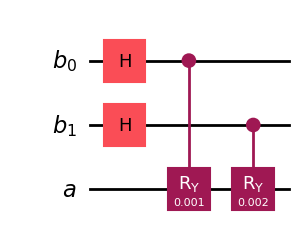

In [4]:
b = b_state(2,'x',0.001)
b.draw('mpl')

In [89]:
function = 'x'
size = 2
b = b_state(size,function,0.001)
state = Statevector(b)
state = state.data.real[2**size:]
state/np.linalg.norm(state)

array([0.        , 0.26726131, 0.53452255, 0.80178366])

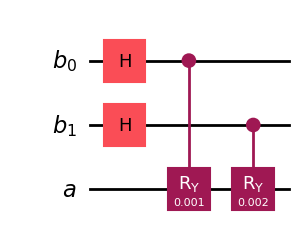

In [90]:
b.draw('mpl')

In [91]:
arr = np.array(b_from_func(function,2**size))
qc = QuantumCircuit(size)
qc.initialize(arr/np.linalg.norm(arr))
state = Statevector(qc)
print(state.data.real)

[0.         0.26726124 0.53452248 0.80178373]


As we can see, we get good results by approximating (except when we include an amplitude a $_0$). This approximation includes an error and an extra ancilla, so we need to test its effectiveness. To do that, we can resolve to make an study of the number of gates, similar to what we did with the HHL circuit.

In [38]:
function = 'x^2+x'
gates1={}
gates2={}
diff_1 = []
for i in range(1,12):
    print(f'Iteration {i}.1, size: {2**i}')
    b = b_state(i,function,10e-8)
    gates1[i] = b.decompose(reps=6).size()
    state = Statevector(b)
    state = state.data.real[2**i:]
    sol1=state/np.linalg.norm(state)
    ########### Second circuit
    print(f'Iteration {i}.2')
    arr = np.array(b_from_func(function,2**i))
    qc = QuantumCircuit(i)
    qc.initialize(arr/np.linalg.norm(arr))
    gates2[i] = qc.decompose(reps=6).size()    
    state = Statevector(qc).data.real
    diff_1.append(np.linalg.norm(np.abs(state-sol1))/2**i)
    
print(f'The number of gates of the approximation approach is {gates1}')
print(f'The number of gates of the exact approach is {gates2}')
print(f'The difference array is {diff_1}')

Iteration 1.1, size: 2
Iteration 1.2
Iteration 2.1, size: 4
Iteration 2.2
Iteration 3.1, size: 8
Iteration 3.2
Iteration 4.1, size: 16
Iteration 4.2
Iteration 5.1, size: 32
Iteration 5.2
Iteration 6.1, size: 64
Iteration 6.2
Iteration 7.1, size: 128
Iteration 7.2
Iteration 8.1, size: 256
Iteration 8.2
Iteration 9.1, size: 512
Iteration 9.2
Iteration 10.1, size: 1024
Iteration 10.2
Iteration 11.1, size: 2048
Iteration 11.2
The number of gates of the approximation approach is {1: 5, 2: 42, 3: 159, 4: 457, 5: 1175, 6: 2892, 7: 7015, 8: 16943, 9: 40791, 10: 97650, 11: 231751}
The number of gates of the exact approach is {1: 2, 2: 7, 3: 16, 4: 33, 5: 50, 6: 67, 7: 84, 8: 101, 9: 118, 10: 135, 11: 152}
The difference array is [0.0, 0.01532659502272172, 0.03384732860524003, 0.02798039761860354, 0.0180793575287153, 0.010560340413306828, 0.005867458420959174, 0.003159967599424082, 0.0014863771038959163, 0.0007556980681267271, 0.0005159924728461602]


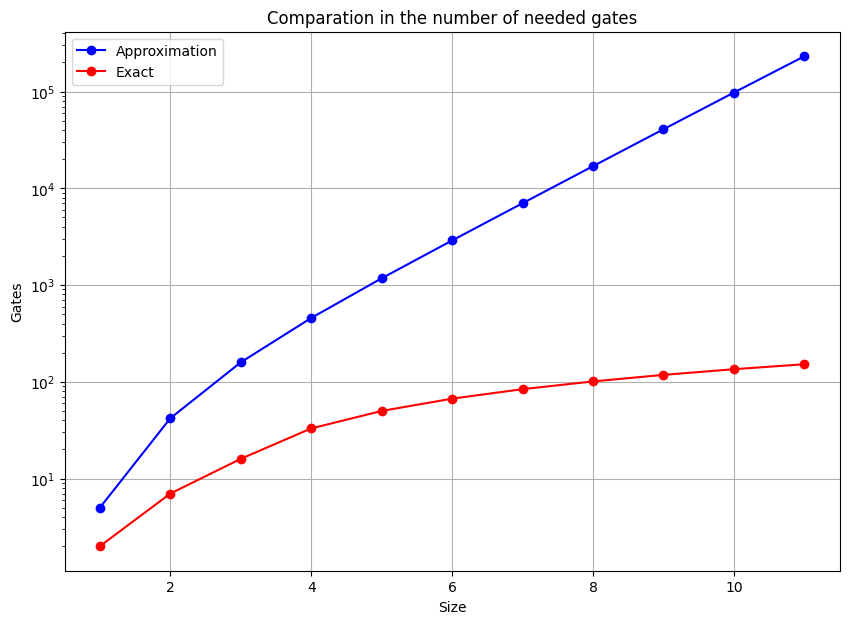

In [39]:
import matplotlib.pyplot as plt

keys_1 = list(gates1.keys())
values_1 = list(gates1.values())
keys = list(gates2.keys())
values = list(gates2.values())

plt.figure(figsize=(10, 7))

plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.yscale('log')
plt.title('Comparation in the number of needed gates')
plt.legend(['Approximation','Exact'])
plt.grid(True)
plt.show()

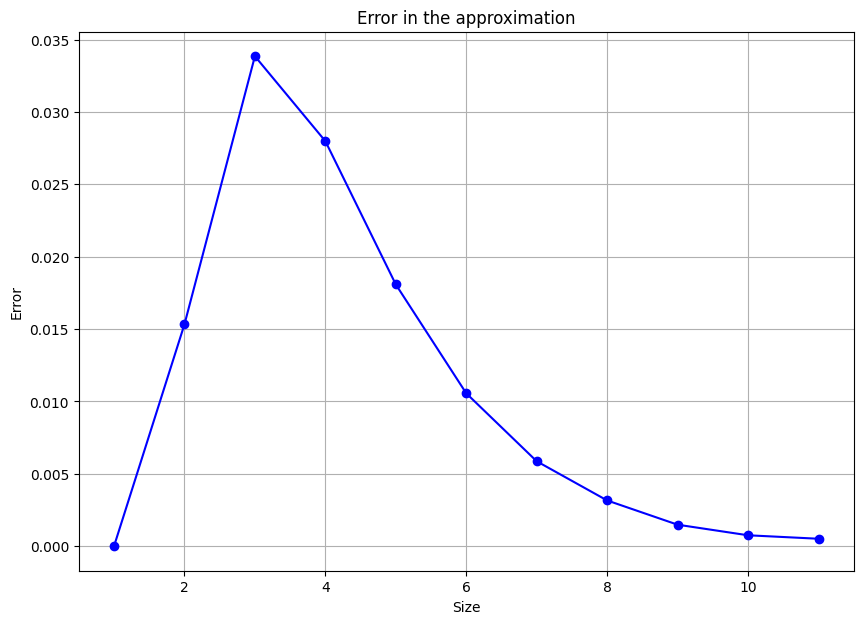

In [40]:
import matplotlib.pyplot as plt

x = np.arange(1,12,1)
plt.figure(figsize=(10, 7))

# for i in range(len(diff)):
#     diff[i]=diff[i]*2**i

plt.plot(x, diff_1, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Error')
plt.title('Error in the approximation')
plt.grid(True)
plt.show()

Using Lagrange interpolation, we can get an analytic expression for the MSE function. Then we can do it for some other initilization functions and see if we get any matches. This way we can extract an approximate error function for this approach.

In [11]:
from scipy.interpolate import lagrange
import sympy as sp

poly = lagrange(x, diff_1)

# Convert to a sympy expression for an analytic expression
x_sym = sp.symbols('x')
poly_expr = sum(round(float(c),3) * x_sym**i for i, c in enumerate(poly.coefficients[::-1]))

print("Lagrange Interpolation Polynomial:")
print(poly_expr)

Lagrange Interpolation Polynomial:
-0.001*x**7 + 0.006*x**6 - 0.043*x**5 + 0.204*x**4 - 0.638*x**3 + 1.213*x**2 - 1.213*x + 0.471


In [41]:
function = 'x^3+3x^2-5x'
gates1={}
gates2={}
diff_2 = []
for i in range(1,10):
    print(f'Iteration {i}.1, size: {2**i}')
    b = b_state(i,function,10e-8)
    gates1[i] = b.decompose(reps=6).size()
    state = Statevector(b)
    state = state.data.real[2**i:]
    sol1=state/np.linalg.norm(state)
    ########### Second circuit
    print(f'Iteration {i}.2')
    arr = np.array(b_from_func(function,2**i))
    qc = QuantumCircuit(i)
    qc.initialize(arr/np.linalg.norm(arr))
    gates2[i] = qc.decompose(reps=6).size()    
    state = Statevector(qc).data.real
    diff_2.append(np.linalg.norm(np.abs(state-sol1))/2**i)
    
print(f'The number of gates of the approximation approach is {gates1}')
print(f'The number of gates of the exact approach is {gates2}')

Iteration 1.1, size: 2
Iteration 1.2
Iteration 2.1, size: 4
Iteration 2.2
Iteration 3.1, size: 8
Iteration 3.2
Iteration 4.1, size: 16
Iteration 4.2
Iteration 5.1, size: 32
Iteration 5.2
Iteration 6.1, size: 64
Iteration 6.2
Iteration 7.1, size: 128
Iteration 7.2
Iteration 8.1, size: 256
Iteration 8.2
Iteration 9.1, size: 512
Iteration 9.2
The number of gates of the approximation approach is {1: 5, 2: 42, 3: 159, 4: 457, 5: 1175, 6: 2892, 7: 7015, 8: 16943, 9: 40791}
The number of gates of the exact approach is {1: 3, 2: 10, 3: 25, 4: 56, 5: 87, 6: 118, 7: 149, 8: 180, 9: 211}


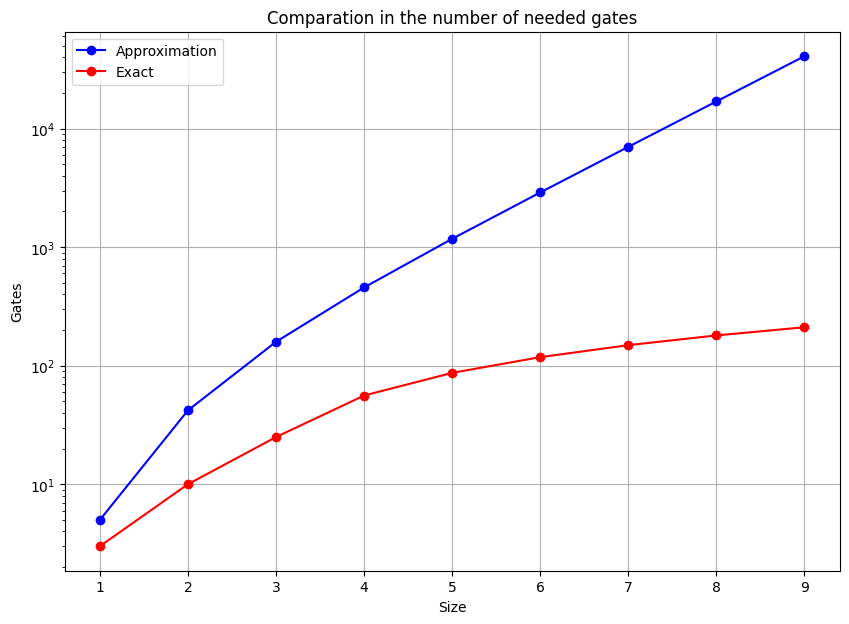

In [41]:
import matplotlib.pyplot as plt

keys_1 = list(gates1.keys())
values_1 = list(gates1.values())
keys = list(gates2.keys())
values = list(gates2.values())

plt.figure(figsize=(10, 7))

plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.yscale('log')
plt.title('Comparation in the number of needed gates')
plt.legend(['Approximation','Exact'])
plt.grid(True)
plt.show()

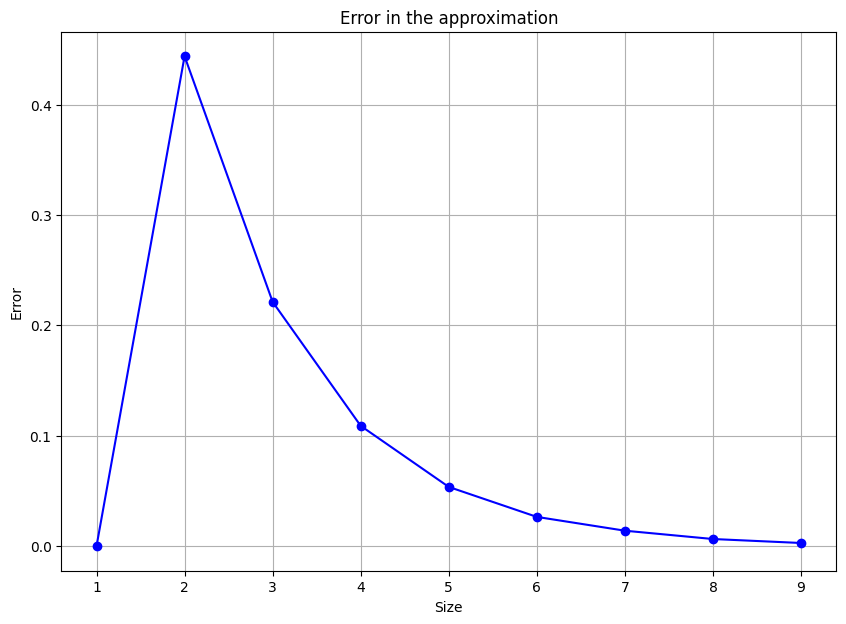

In [42]:
import matplotlib.pyplot as plt

x = np.arange(1,10,1)
plt.figure(figsize=(10, 7))

plt.plot(x, diff_2, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Error')
plt.title('Error in the approximation')
plt.grid(True)
plt.show()

In [22]:
from scipy.interpolate import lagrange
import sympy as sp

poly = lagrange(x, diff_2)

# Convert to a sympy expression for an analytic expression
x_sym = sp.symbols('x')
poly_expr = sum(float(c) * x_sym**i for i, c in enumerate(poly.coefficients[::-1]))

print("Lagrange Interpolation Polynomial:")
print(poly_expr)

Lagrange Interpolation Polynomial:
-2.08939822021939e-5*x**8 + 0.000923003409430392*x**7 - 0.0173899623373943*x**6 + 0.182072788905938*x**5 - 1.15498386101907*x**4 + 4.52331000316471*x**3 - 10.5789540051212*x**2 + 13.1816079094762*x - 6.13656498249648


We can improve the fitting of the interpolation using other functions. To do that, first, we have to remove the first factors, because they don't follow the norm of the other ones. Then we can apply the fitting. Based on the looks of the function, we can assume that it must be one of these two types:
- An exponential function: $a+be^{-cx}$
- An inverse function: $a+\frac{b}{x^c}$

We define the functions and then run the scipy function `curve_fit`

In [110]:
from scipy.optimize import curve_fit

def func1(x, a, b, c):
    return a * np.exp(-b * x) + c

def func2(x,a,b,c):
    return a + b/(x**c)

x1 = np.arange(4,12,1)
x2 = np.arange(4,10,1)

diff_1 = np.array(diff_1)
diff_2 = np.array(diff_2)

# Only to use the first time
# diff_1 = diff_1[3:]
# diff_2 = diff_2[3:]

popt1,pcov1 = curve_fit(func1,x1,diff_1,p0=[1.0, 0.1, 1.0])

popt2,pcov2 = curve_fit(func2,x1,diff_1)

popt3,pcov3 = curve_fit(func1,x2,diff_2,p0=[1.0, 0.1, 1.0])

popt4,pcov4 = curve_fit(func2,x2,diff_2)

print('-FUNCTION 2')
print(f'The parameters using the exponential function are: {popt1}')
print(f'The parameters using the inverse function are: {popt2}')
print(f'---------------------------------------------------------------------\n-FUNCTION 2')
print(f'The parameters using the exponential function are: {popt3}')
print(f'The parameters using the inverse function are: {popt4}')

-FUNCTION 2
The parameters using the exponential function are: [ 0.18688967  0.46222365 -0.00113862]
The parameters using the inverse function are: [-0.00562629  0.44067819  1.84700165]
---------------------------------------------------------------------
-FUNCTION 2
The parameters using the exponential function are: [1.81204073e+00 7.03039041e-01 5.54302824e-05]
The parameters using the inverse function are: [-0.00883663  6.7020401   2.91361774]


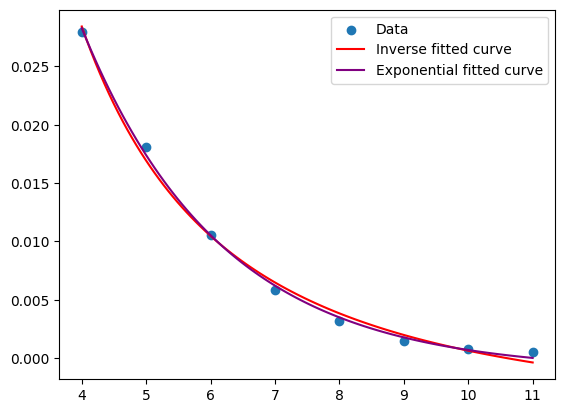

In [111]:
plt.scatter(x1, diff_1, label='Data')
x = np.linspace(4,11,100)
plt.plot(x, func2(x, *popt2), label='Inverse fitted curve', color='red')
plt.plot(x, func1(x, *popt1), label='Exponential fitted curve', color='purple')
plt.legend()
plt.show()

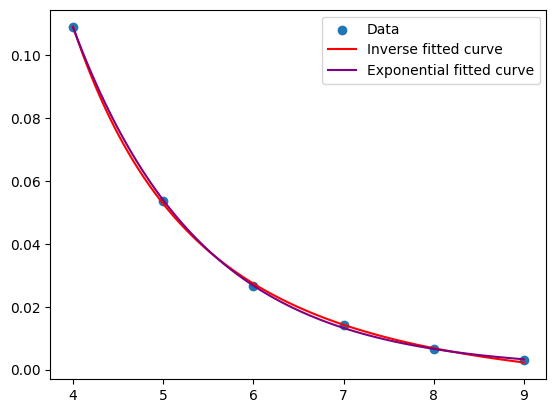

In [112]:
plt.scatter(x2, diff_2, label='Data')
x = np.linspace(4,9,100)
plt.plot(x, func2(x, *popt4), label='Inverse fitted curve', color='red')
plt.plot(x, func1(x, *popt3), label='Exponential fitted curve', color='purple')
plt.legend()
plt.show()

As we can see, the fitting is really good with both functions, but the exponential approach seems to work better for the seeming evolution. With this, we can deduce that the profile of the MSE is a negative exponential. This is really good, as it implies a good approximation when the size of the problem increases.

With this study finished we can start importing this approximation into the HHL algorithm as the initialization of the right-hand side vector

---

## Implementation for HHL

To do this, we will include a new optional argument in the function, that indicates the function mapping the right-hand side vector of the approximation. As the paper [2] indicates, the $c$ is going to be chosen as $\sqrt{\varepsilon_p}$, depending in the tolerance of the whole algorithm.

In [52]:
#Function to build the HHL circuit
def build_circuit_test(matrix, vector, tolerance: float = 10e-3, flag: bool = True, meas: bool = False,fnc: str = None,c=1):
    """
    Builds the HHL circuit using the required args
    
    Args:
        `matrix`: The matrix that defines the linear system, i.e. A in Ax = b.
        `vector`: The right-hand side of the equation, i.e. b in Ax = b.
        `tolerance`: Tolerance of the solution bounds. This value is used to define the 3 tolerances needed for the HHL [2] equation (62).
        `flag`: Flag deciding whether the reciprocal circuit is or not exact
        `meas`: Flag deciding whether measures are made in the non x qubits
        `fnc`: String selecting the function to map the values to b. The style is: 'ax^n+...+bx+c'
        
    Returns:
        The HHL circuit
    
    Raises:
        ValueError: If the data is not in the right format
        ValueError: The matrix dimension is not correct
    """
    
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # Number of ancillas of the vector init
    anc = False
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray,int)):
        if isinstance(vector,list):
            vector = np.array(vector)
        
        # We define the number of needed qubits and insert the vector to the register
        
        if isinstance(vector,int):
            nb = vector
        else:
            nb = int(np.log2(len(vector)))
        
        if fnc is None:            
            vector_circuit = QuantumCircuit(nb)
            vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
        
        else:
            # Could be calculated in O(N) time, so we input an approximation of Cb to calculate in O(1)
            # Cb = 0.9
            # c = epsilon_s/(8*Cb)
            vector_circuit = b_state(nb,fnc,c)
            anc = True
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    
    # Define flag, if 1, correct solution, if 0, incorrect
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        # if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
        #     raise ValueError(
        #         "Input vector dimension does not match input "
        #         "matrix dimension! Vector dimension: "
        #         + str(vector_circuit.num_qubits)
        #         + ". Matrix dimension: "
        #         + str(matrix.shape[0])
        #     )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)

        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    if flag:
        reciprocal_circuit = ExactReciprocal(nl, delta)
        # Update number of ancilla qubits
        na = matrix_circuit.num_ancillas
    
    # Using Chebyshev interpolation to approximate arcsin(C/x) to a degree of degree
    else: 
        # Calculate breakpoints for the reciprocal approximation
        num_values = 2 ** nl
        constant = delta
        
        # No tengo para nada claro esto, no encuentro que hay que hacer con la a para pasarla a entero
        a = int(2**(2*nl/3))  # pylint: disable=invalid-name

        # Calculate the degree of the polynomial and the number of intervals
        r = 2 * constant / a + np.sqrt(np.abs(1 - (2 * constant / a) ** 2))
        degree = min(nb,int(np.log(1+(16.23* np.sqrt(np.log(r) ** 2 + (np.pi / 2) ** 2)* kappa* (2 * kappa - epsilon_r))/ epsilon_r)),)
        # As [2]
        num_intervals = int(np.ceil(np.log((num_values - 1) / a) / np.log(5)))

        # Calculate breakpoints and polynomials
        breakpoints = []
        for i in range(0, num_intervals):
            # Add the breakpoint to the list
            breakpoints.append(a * (5 ** i))

            # Define the right breakpoint of the interval
            if i == num_intervals - 1:
                breakpoints.append(num_values - 1)
        # Once we have the intervals, and everything is defined, we can make an approximation by a polynomial function of degree
        reciprocal_circuit = PiecewiseChebyshev(
            lambda x: np.arcsin(constant / x), degree, breakpoints, nl, name="c_Rot"
        )
        # Number of ancilla qubits
        na = max(matrix_circuit.num_ancillas, reciprocal_circuit.num_ancillas)
        
    # Construction of the circuit
        
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    if na > 0:
        qa = AncillaRegister(na,name="anc")  # ancilla qubits
    if anc:
        qab = AncillaRegister(1,name='a_b') # ancilla qubit for the approximation of b
    qf = QuantumRegister(nf,name="flag")  # flag qubits

    if na > 0:
        if anc:
            qc = QuantumCircuit(qb, ql, qa, qab, qf)
        else:
            qc = QuantumCircuit(qb, ql, qa, qf)
    else:
        if anc:
            qc = QuantumCircuit(qb, ql, qab, qf)
        else:
            qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    if anc:
        qc.append(vector_circuit, qb[:] + qab[:])
    else:
        qc.append(vector_circuit, qb[:])
    qc.barrier(label="\pi_1")
    # QPE
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    if na > 0:
        qc.append(phase_estimation, ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation, ql[:] + qb[:])
    qc.barrier(label="\pi_2")
    # Conditioned rotation
    if flag:
        qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
    else:
        qc.append(
            reciprocal_circuit.to_instruction(),
            ql[::-1] + [qf[0]] + qa[: reciprocal_circuit.num_ancillas],
        )
    
    qc.barrier(label="\pi_3")
    # QPE inverse
    if na > 0:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:])
    
    if meas:
        qc.measure_all()
    return qc,scaling

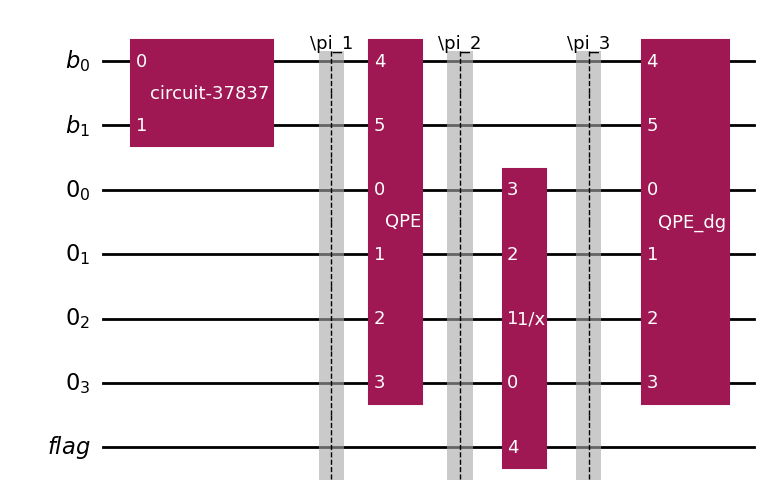

In [54]:
vector = np.array([1]*4)
matrix=tridiag_matrix(2,-1,4)
hhl,_ = build_circuit_test(matrix,vector)
hhl.draw('mpl')

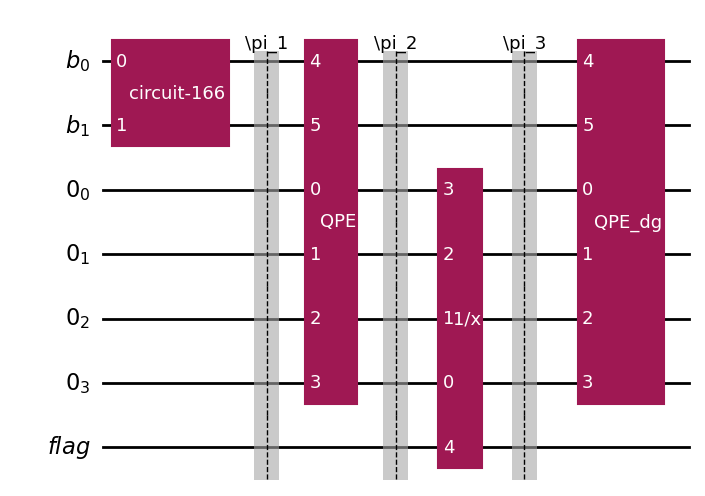

In [5]:
vector = np.array(b_from_func('x',4))
matrix = tridiag_matrix(2,-1,4)
hhl2,_ = build_circuit_test(matrix,vector,flag=True)
hhl2.decompose(reps=0).draw('mpl')

In [7]:
print(solution(hhl,flag=True))

[0.25540959 0.51306228 0.63945808 0.51247089]


In [164]:
solution(hhl2)

array([0.255, 0.513, 0.639, 0.512])

In [8]:
s=np.linalg.solve(matrix,np.array(b_from_func('x',4)))
s/np.linalg.norm(s)

array([0.25607376, 0.51214752, 0.6401844 , 0.51214752])

Now we know that this works with statevectors, but we have to try with shots, that are the solutions we get from a real QPU

In [9]:
def ampl_from_sim(qc,shots=8192):
    sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)
    sampler = SamplerV2()
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1+1)]

    prob = []
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

In [13]:
len(ampl_from_sim(hhl))

256

We got a **big problem** here. With the actual approach the amplitudes of the values of the solution where the ancilla qubit is 0 are really small. With this in hand, we dont get any shot that measures this values. We need a way to make the probabilities of measuring a 1 much higher. 

Using [2] as a base, due to the implementation, we have that the probability of measuring $|1>$ in the ancilla qubit must be higher than $\frac{c^2}{C_b^2}-c^4$, then

In [215]:
epsilon_s = 10e-3
Cb = 0.9
c = epsilon_s/(8*Cb)


prob = c**2/Cb**2-c**4
display(Markdown(f'#### The probability must be higher than {prob}'))

#### The probability must be higher than 2.381493001971879e-06

We can test this:

In [210]:
st = Statevector(hhl)
st = st.data.real
num = int(len(st)/2) + 64
for i in range(4):
    print(st[num+i]>prob)

True
True
True
True


To improve this probability we can increase the value of $c$, but by doing this, the error of the solution worsens. If we want to achieve a good solution we need to make a compromise. This is increasingly important if we want to make the measurements of the circuit by shots.

In [247]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)
hhl_bigc,_ = build_circuit_test(matrix,vector,fnc='x')

In [248]:
st = Statevector(hhl_bigc)
st = st.data.real
num = int(len(st)/2) + 64
sol = []
for i in range(4):
    sol.append(st[num+i])
sol = sol/np.linalg.norm(sol)
sol

array([0.255, 0.513, 0.639, 0.512])

## Study of the probabilities of the solution and $c$

We can study how the value of $c$ influences the probabilities of measuring the real solution to the problem

In [95]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)

arr = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75,1]

# Analytic solution
s=np.linalg.solve(matrix,np.array(b_from_func('x^2',4)))
s=s/np.linalg.norm(s)

norm = []
prob = {}
diff = []

for c in arr:
    hhl,_ = build_circuit_test(matrix,vector,fnc='x^2-x',c=c)
    st = Statevector(hhl).data.real[192:196] **2
    norm.append(np.linalg.norm(st))
    prob[c] = st
    diff.append(st/np.linalg.norm(st)-s)
    

In [96]:
norm

[1.951168737190339e-10,
 4.877921741144161e-09,
 1.9511685691680628e-08,
 4.877911239761996e-07,
 1.9511517670074997e-06,
 4.876861206514848e-05,
 0.00019494722226332916,
 0.004772901441201985,
 0.017880794758143137,
 0.07000970175867947,
 0.05025835700708324,
 0.01532001777879819,
 0.034735346969986536]

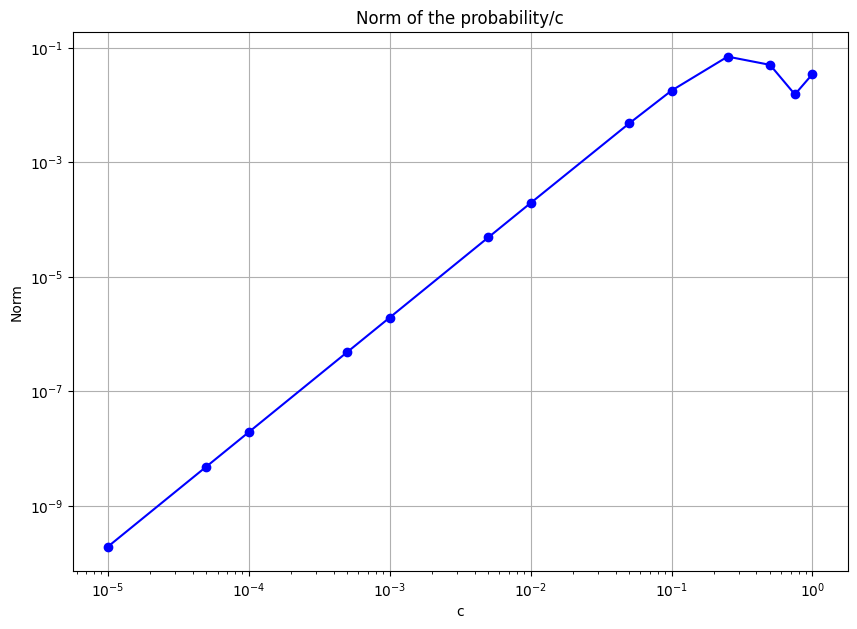

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(arr, norm, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Norm')
plt.title('Norm of the probability/c')
plt.grid(True)
plt.show()

Seeing that we get a linear evolution in [$10^{-5}$,$0.1$], we can study more in depth what happens in [$0.1,1$]

In [26]:
vector = 2
matrix=tridiag_matrix(2,-1,2**vector)

arr = np.linspace(0.1,1,100)

function = 'x^3'

# Analytic solution
s=np.linalg.solve(matrix,np.array(b_from_func(function,4)))
s=s/np.linalg.norm(s)

norm = []
prob = {}
diff = []

for c in arr:
    hhl,_ = build_circuit_test(matrix,vector,fnc=function,c=c)
    st = Statevector(hhl).data.real[192:196]**2
    norm.append(np.linalg.norm(st))
    prob[c] = st
    diff.append(st/np.linalg.norm(st)-s)

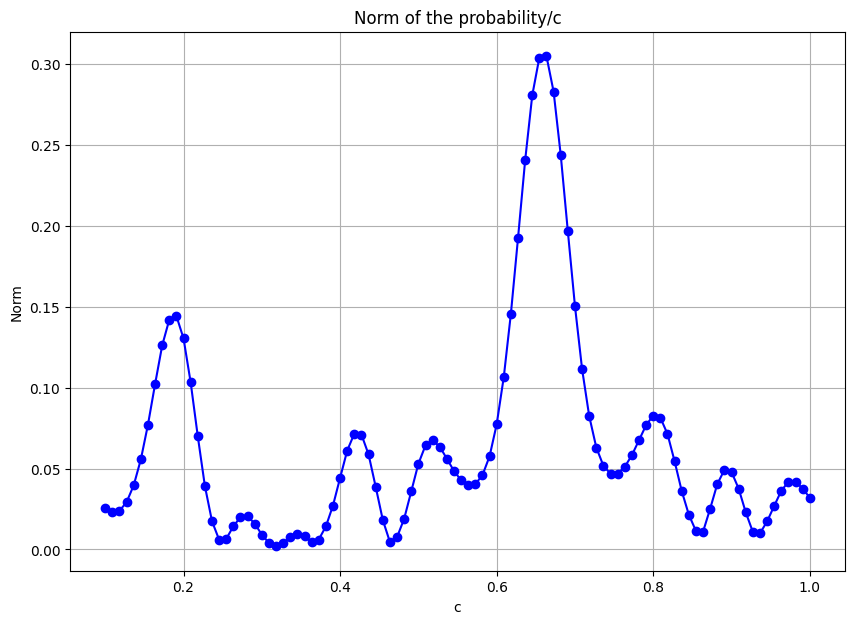

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(arr, norm, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.ylabel('Norm')
plt.title('Norm of the probability/c')
plt.grid(True)
plt.show()

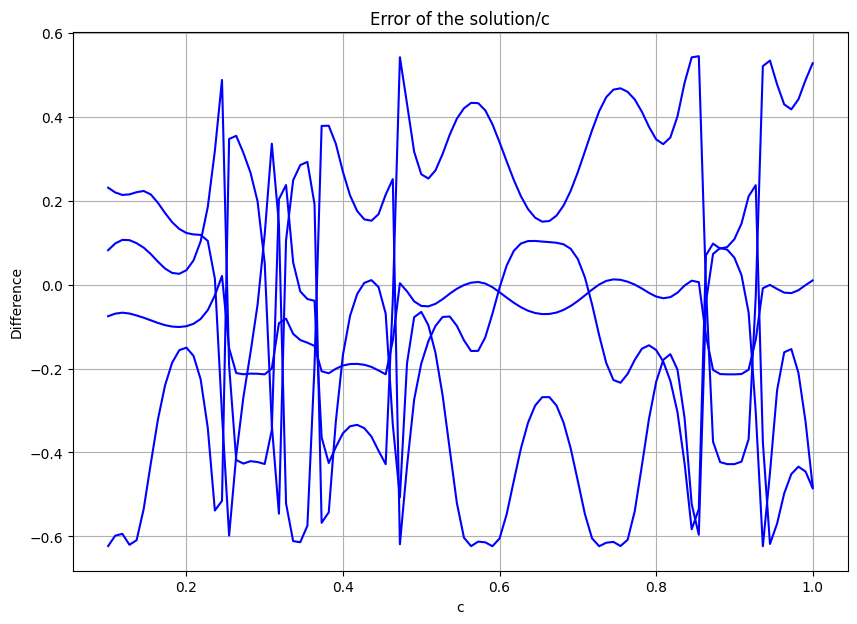

In [28]:
plt.figure(figsize=(10, 7))

plt.plot(arr, diff, linestyle='-', color='blue')
plt.xlabel('c')
plt.ylabel('Difference')
plt.title('Error of the solution/c')
plt.grid(True)
plt.show()

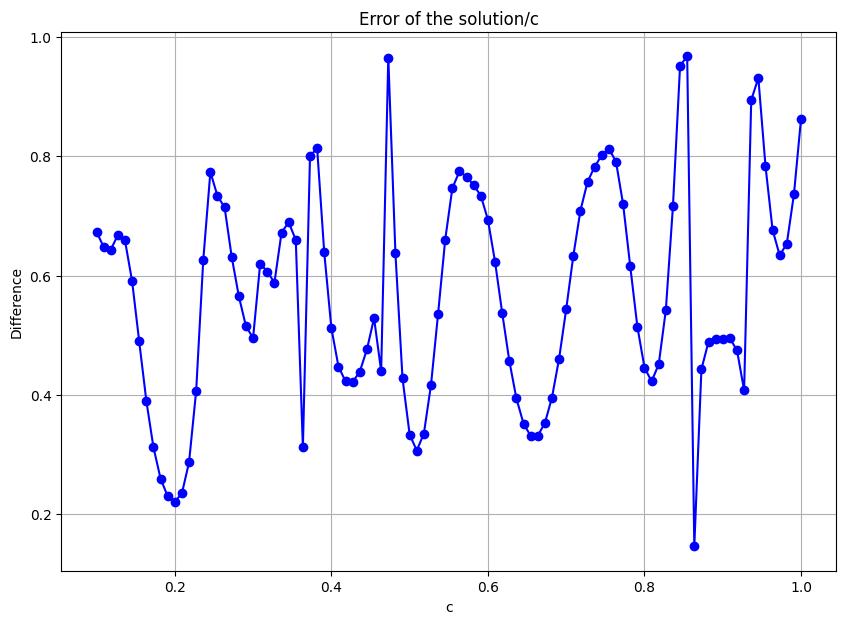

In [29]:
plt.figure(figsize=(10, 7))

norma = [np.linalg.norm(diff[i]) for i in range(len(diff))]

plt.plot(arr, norma, marker='o', linestyle='-', color='blue')
plt.xlabel('c')
plt.ylabel('Difference')
plt.title('Error of the solution/c')
plt.grid(True)
plt.show()

## Fourier analysis

Given the shape of the norm of the probability, it seems it comes from a Fourier series. To get more information from this, we can make a Fourier analysis to get the waves that generate this functions.

In [19]:
from scipy.fft import fft
from scipy.signal import find_peaks

Frequency: 0.00 Hz, Magnitude: 6.37+0.00j
Frequency: 3.30 Hz, Magnitude: 0.97+0.36j
Frequency: 8.80 Hz, Magnitude: 0.68+0.89j


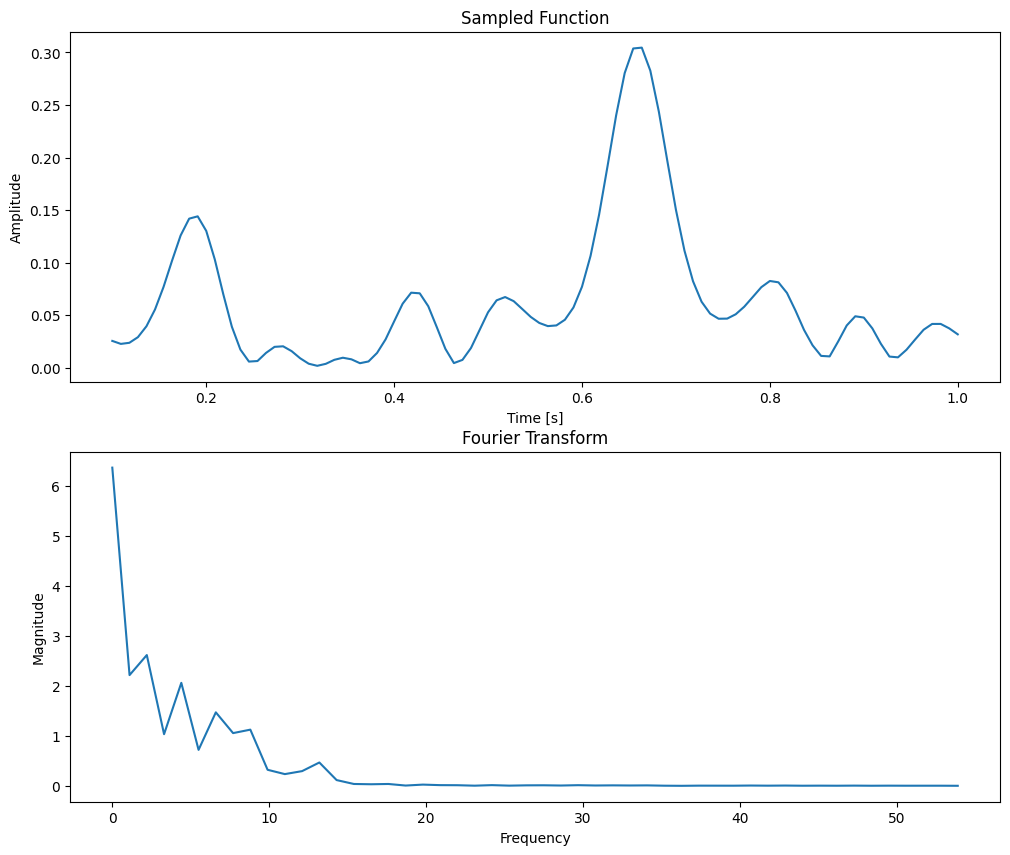

In [40]:
ampl = np.fft.fft(norm)

sampling_rate = len(arr) / (arr[-1] - arr[0]) 
freqs = np.fft.fftfreq(len(ampl), d=(arr[1] - arr[0]) )

positive_freq_indices = np.where(freqs >= 0)
positive_fft_result = ampl[positive_freq_indices]
positive_fft_freq = freqs[positive_freq_indices]


#print(ampl)
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)

plt.plot(arr, norm)
plt.title('Sampled Function')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the magnitude of the FFT result
plt.subplot(2, 1, 2)
plt.plot(positive_fft_freq, np.abs(positive_fft_result))  # Only plot the positive frequencies
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')


significant_indices = np.where(positive_fft_result > np.max(positive_fft_result) * 0.1)[0]
significant_freqs = positive_fft_freq[significant_indices]
significant_magnitudes = positive_fft_result[significant_indices]

# Print significant frequencies and their magnitudes
for freq, magnitude in zip(significant_freqs, significant_magnitudes):
    print(f"Frequency: {freq:.2f} Hz, Magnitude: {magnitude:.2f}")